# OLS Analysis Using 2013-2016 PSU dataset

In [1]:
#Import required packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(4,6)
    df_date['Term_Date'] = pd.to_datetime(df_date['Year'] + df_date['Quarter'], format='%Y%m')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl   
    

## Partitioning a dataset in training and test sets

In [5]:
pd.set_option('display.max_rows', None)  


df = pd.read_csv('data/PSU_master_classroom.csv', dtype={'Schedule': object, 'Schedule Desc': object})
df = df.fillna('')

df = format_date(df)
# Avoid classes that only occur on a single day
df = df.loc[df['Start_Date'] != df['End_Date']]
df = df.loc[df['Online Instruct Method'] != 'Fully Online']

# Calculate number of days per week and treat Sunday condition
df['Days_Per_Week'] = df['Days'].str.len()
df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
df['Building'] = df['ROOM'].str.extract('([^\s]+)', expand=True)

df_cl = format_xlist(df)
df_cl['%_Empty'] = df_cl['Cap_Diff'].astype(float) / df_cl['Room_Capacity'].astype(float)

# Normalize the results
df_cl['%_Empty'] = df_cl['Actual_Enrl'].astype(np.float32)/df_cl['Room_Capacity'].astype(np.float32)
df_cl = df_cl.replace([np.inf, -np.inf], np.nan).dropna()

print(df_cl.isnull().values.any())


from sklearn.preprocessing import LabelEncoder

y = np.asarray(df_cl['%_Empty'], dtype="|S6")
df_cl = df_cl[['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Term', 'Room_Capacity', 'Building']]

cat_columns = ['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Building']

for column in cat_columns:
    room_mapping = {label: idx for idx, label in enumerate(np.unique(df_cl['{0}'.format(column)]))}
    df_cl['{0}'.format(column)] = df_cl['{0}'.format(column)].map(room_mapping)

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
    
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df_cl.iloc[:, 1:].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)





C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


False


 1) Class                          0.294870
 2) Term                           0.230028
 3) Start_Time                     0.181642
 4) ROOM                           0.103405
 5) Days                           0.102662
 6) Room_Capacity                  0.059847
 7) Building                       0.027546


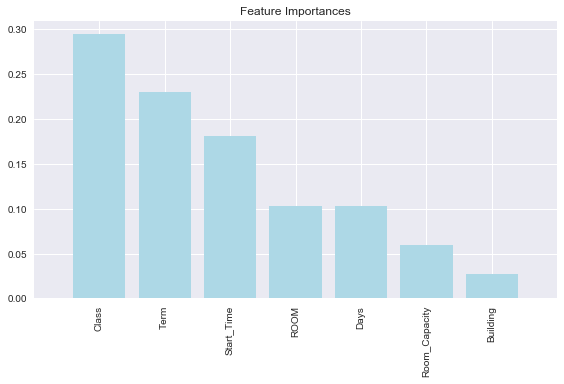

In [6]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_cl.columns[1:]

forest = RandomForestClassifier(n_estimators=50,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

# Load libraries
import pandas
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)